In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import random
plt.style.use("ggplot")
plt.rcParams['image.cmap'] = 'inferno'

Now we look at an enhanced 5x5 GridWorld with terminal states for episodic tasks.We know that the terminal states are located at: (2,0), (2,4), (4,0), (4,4) and our rewarding systems is that;


- Blue square (0,1): +5 reward, jump to red (4,1)
- Green square (0,3): +2.5 reward, jump to (2,3) or (4,1) with equal probability
- Any move from white/yellow/red square: -0.2 reward
- Boundary attempts: -0.5 reward
- Terminal states: 0 reward (episode ends)


In [5]:
class GridWorldWithTerminals:


    def __init__(self, GridSize=5, DiscountFactor=0.95):
        self.GridSize = GridSize
        self.States = [(i, j) for i in range(GridSize) for j in range(GridSize)]
        self.DiscountFactor = DiscountFactor
        self.Actions = ['Up', 'Down', 'Left', 'Right']

        # Define special states
        self.BlueState = (0, 1)
        self.GreenState = (0, 3)
        self.RedState = (4, 1)
        self.YellowState = (4, 4)  # Note: This is now a terminal state

        # Define terminal states (black squares)
        self.TerminalStates = {(2, 0), (2, 4), (4, 0), (4, 4)}

        # Non-terminal states for learning
        self.NonTerminalStates = [state for state in self.States
                                 if state not in self.TerminalStates]

    def IsTerminal(self, state): # we want to Check if a state is terminal

        return state in self.TerminalStates

    def GetNextState(self, state, action):

        if self.IsTerminal(state):
            return state, 0, True

        i, j = state

        # Handle special states first
        if state == self.BlueState:
            NextState = self.RedState
            Reward = 5
            return NextState, Reward, self.IsTerminal(NextState)

        if state == self.GreenState:
            # 50% chance to go to (2,3) or (4,1)
            if np.random.random() < 0.5:
                NextState = (2, 3)
            else:
                NextState = self.RedState
            Reward = 2.5
            return NextState, Reward, self.IsTerminal(NextState)

        # Normal movement
        NewI, NewJ = i, j

        if action == 'Up':
            NewI = max(i-1, 0)
        elif action == 'Down':
            NewI = min(i+1, self.GridSize-1)
        elif action == 'Left':
            NewJ = max(j-1, 0)
        elif action == 'Right':
            NewJ = min(j+1, self.GridSize-1)

        NextState = (NewI, NewJ)

        # Determine reward based on the rules
        if (NewI, NewJ) == (i, j) and self._IsBoundaryState(state):
            # Tried to move off grid
            Reward = -0.5
        else:
            # Any move from white/yellow/red square
            Reward = -0.2

        return NextState, Reward, self.IsTerminal(NextState)

    def _IsBoundaryState(self, state): # we want to also check if state is on the boundary of the grid

        i, j = state
        return i == 0 or i == self.GridSize-1 or j == 0 or j == self.GridSize-1

    def GenerateEpisode(self, Policy, StartState=None, MaxSteps=1000):

        if StartState is None: # we're starting from a random non-terminal state

            StartState = random.choice(self.NonTerminalStates)

        Episode = []
        CurrentState = StartState

        for _ in range(MaxSteps):
            if self.IsTerminal(CurrentState):
                break

            # Choose action according to policy
            if isinstance(Policy, dict):
                Action = Policy.get(CurrentState, random.choice(self.Actions))
            else:
                # Assume policy is a function
                Action = Policy(CurrentState)

            # Take action and observe result
            NextState, Reward, IsTerminal = self.GetNextState(CurrentState, Action)

            Episode.append((CurrentState, Action, Reward))
            CurrentState = NextState

            if IsTerminal:
                break

        return Episode


Env = GridWorldWithTerminals()
print(f"\nEnvironment created with {len(Env.TerminalStates)} terminal states")
print(f"Terminal states: {Env.TerminalStates}")
print(f"Non-terminal states: {len(Env.NonTerminalStates)}")


Environment created with 4 terminal states
Terminal states: {(4, 4), (2, 4), (4, 0), (2, 0)}
Non-terminal states: 21


In [6]:
class MonteCarloAgent:

    def __init__(self, Environment, Epsilon=0.1):
        self.Environment = Environment
        self.Epsilon = Epsilon

        # Initializing the value functions and visit counts
        self.StateValues = {state: 0.0 for state in Environment.States}
        self.ActionValues = {state: {action: 0.0 for action in Environment.Actions}
                            for state in Environment.States}
        self.StateVisits = {state: 0 for state in Environment.States}
        self.ActionVisits = {state: {action: 0 for action in Environment.Actions}
                            for state in Environment.States}

        # Initializing random policy
        self.Policy = {state: random.choice(Environment.Actions) for state in Environment.States}

    def EpsilonGreedyPolicy(self, state): #Epsilon-greedy action selection

        if random.random() < self.Epsilon:
            return random.choice(self.Environment.Actions)
        else:
            # we want to also choose the action with highest Q-value
            BestActions = [action for action, value in self.ActionValues[state].items()
                          if value == max(self.ActionValues[state].values())]
            return random.choice(BestActions)

    def MonteCarloExploringStarts(self, NumEpisodes=10000):

        print(f"Monte Carlo with Exploring Starts for {NumEpisodes} episodes...")

        for EpisodeNum in range(NumEpisodes):
            # Generate episode with exploring starts
            StartState = random.choice(self.Environment.NonTerminalStates)
            StartAction = random.choice(self.Environment.Actions)

            # Generate episode starting with the random state-action pair
            Episode = self._GenerateEpisodeWithStartAction(StartState, StartAction)

            # Calculate returns and update values
            self._UpdateFromEpisode(Episode)

            if (EpisodeNum + 1) % 2000 == 0:
                AvgEpisodeLength = np.mean([len(self._GenerateEpisodeWithStartAction(
                    random.choice(self.Environment.NonTerminalStates),
                    random.choice(self.Environment.Actions))) for _ in range(100)])
                print(f"Episode {EpisodeNum + 1}: Average episode length = {AvgEpisodeLength:.1f}")

        return self.StateValues.copy(), self.Policy.copy()

    def MonteCarloEpsilonSoft(self, NumEpisodes=10000):

        print(f"Monte Carlo with Epsilon-Soft Policy for {NumEpisodes} episodes...")

        for EpisodeNum in range(NumEpisodes):

            StartState = random.choice(self.Environment.NonTerminalStates)
            Episode = self.Environment.GenerateEpisode(self.EpsilonGreedyPolicy, StartState)

            # Updating the action values and policy
            self._UpdateActionValuesFromEpisode(Episode)
            self._UpdatePolicyFromActionValues()

            if (EpisodeNum + 1) % 2000 == 0:
                AvgEpisodeLength = np.mean([len(self.Environment.GenerateEpisode(
                    self.EpsilonGreedyPolicy, random.choice(self.Environment.NonTerminalStates)))
                    for _ in range(100)])
                print(f"Episode {EpisodeNum + 1}: Average episode length = {AvgEpisodeLength:.1f}")

        return self.StateValues.copy(), self.Policy.copy()

    def _GenerateEpisodeWithStartAction(self, StartState, StartAction): # We want to generate episode starting with specific state-action pair

        Episode = []
        CurrentState = StartState

        # Now we take the specified first action
        NextState, Reward, IsTerminal = self.Environment.GetNextState(CurrentState, StartAction)
        Episode.append((CurrentState, StartAction, Reward))
        CurrentState = NextState

        # After that we want to continue with the current policy
        while not self.Environment.IsTerminal(CurrentState) and len(Episode) < 1000:
            Action = self.Policy.get(CurrentState, random.choice(self.Environment.Actions))
            NextState, Reward, IsTerminal = self.Environment.GetNextState(CurrentState, Action)
            Episode.append((CurrentState, Action, Reward))
            CurrentState = NextState

        return Episode

    def _UpdateFromEpisode(self, Episode): #We want to update state values and policy from episode

        VisitedStates = set()
        G = 0  # A Return

        # Working backwards through episode
        for i in range(len(Episode) - 1, -1, -1):
            State, Action, Reward = Episode[i]
            G = self.Environment.DiscountFactor * G + Reward

            # First-visit Monte Carlo
            if State not in VisitedStates:
                VisitedStates.add(State)

                # Updating state value
                self.StateVisits[State] += 1
                Alpha = 1.0 / self.StateVisits[State]  # Decreasing step size
                self.StateValues[State] += Alpha * (G - self.StateValues[State])

        # Updating the policy to be greedy and with respect to current state values
        self._UpdatePolicyGreedy()

    def _UpdateActionValuesFromEpisode(self, Episode): #Updating action values from episode

        VisitedStateActions = set()
        G = 0

        for i in range(len(Episode) - 1, -1, -1):
            State, Action, Reward = Episode[i]
            G = self.Environment.DiscountFactor * G + Reward

            StateAction = (State, Action)
            if StateAction not in VisitedStateActions:
                VisitedStateActions.add(StateAction)

                self.ActionVisits[State][Action] += 1
                Alpha = 1.0 / self.ActionVisits[State][Action]
                self.ActionValues[State][Action] += Alpha * (G - self.ActionValues[State][Action])

    def _UpdatePolicyGreedy(self): #Updating policy to be greedy with respect to state values

        for State in self.Environment.NonTerminalStates:
            BestAction = None
            BestValue = -np.inf

            for Action in self.Environment.Actions:
                # Estimating action value by looking ahead one step
                NextState, Reward, _ = self.Environment.GetNextState(State, Action)
                ActionValue = Reward + self.Environment.DiscountFactor * self.StateValues[NextState]

                if ActionValue > BestValue:
                    BestValue = ActionValue
                    BestAction = Action

            self.Policy[State] = BestAction

    def _UpdatePolicyFromActionValues(self):

        for State in self.Environment.NonTerminalStates:
            BestActions = [action for action, value in self.ActionValues[State].items()
                          if value == max(self.ActionValues[State].values())]
            self.Policy[State] = random.choice(BestActions)



Monte Carlo agent implementation complete!


In [7]:
def PlotGridWorldWithTerminals(Values, Title, Environment):

    Grid = np.zeros((5, 5))

    # Filling the grid with values
    for (i, j), v in Values.items():
        Grid[i, j] = v


    plt.figure(figsize=(10, 8))


    Im = plt.imshow(Grid, cmap='inferno', aspect='equal')
    plt.colorbar(Im, label='State Value', shrink=0.8)
    plt.title(Title, fontsize=16, fontweight='bold', pad=20)

    for i in range(5):
        for j in range(5):
            State = (i, j)


            Color = 'white' if Grid[i, j] < np.max(Grid) * 0.6 else 'yellow'


            if not Environment.IsTerminal(State):
                plt.text(j, i, f"{Grid[i, j]:.1f}", ha='center', va='center',
                        color=Color, fontweight='bold', fontsize=11)

            # Adding state type indicators
            if State == Environment.BlueState:
                plt.text(j, i-0.35, "BLUE", ha='center', va='center',
                        color='cyan', fontweight='bold', fontsize=8)
            elif State == Environment.GreenState:
                plt.text(j, i-0.35, "GREEN", ha='center', va='center',
                        color='lime', fontweight='bold', fontsize=8)
            elif State == Environment.RedState:
                plt.text(j, i-0.35, "RED", ha='center', va='center',
                        color='red', fontweight='bold', fontsize=8)
            elif Environment.IsTerminal(State):
                plt.text(j, i, "TERM", ha='center', va='center',
                        color='white', fontweight='bold', fontsize=10)
                # Adding border around terminal states
                Rect = plt.Rectangle((j-0.45, i-0.45), 0.9, 0.9,
                                   fill=False, edgecolor='white', linewidth=3)
                plt.gca().add_patch(Rect)

    plt.xlabel('Column', fontsize=12)
    plt.ylabel('Row', fontsize=12)
    plt.xticks(range(5))
    plt.yticks(range(5))
    plt.tight_layout()
    plt.show()

def PrintPolicyWithTerminals(Policy, Environment):
    ActionSymbols = {
        'Up': '↑', 'Down': '↓', 'Left': '←', 'Right': '→'
    }

    print("\nLearned Policy:")
    print("-" * 25)

    for i in range(5):
        RowItems = []
        for j in range(5):
            State = (i, j)
            if Environment.IsTerminal(State):
                RowItems.append("TERM")
            else:
                Action = Policy.get(State, '?')
                Symbol = ActionSymbols.get(Action, '?')
                RowItems.append(f" {Symbol} ")

        Row = '|' + '|'.join(RowItems) + '|'
        print(Row)
    print("-" * 25)

def AnalyzePolicyPerformance(Agent, NumTestEpisodes=1000):
    EpisodeLengths = []
    EpisodeReturns = []

    for _ in range(NumTestEpisodes):
        StartState = random.choice(Agent.Environment.NonTerminalStates)
        Episode = Agent.Environment.GenerateEpisode(Agent.Policy, StartState)

        EpisodeLengths.append(len(Episode))

        # Calculating the episode return
        G = 0
        for _, _, Reward in reversed(Episode):
            G = Agent.Environment.DiscountFactor * G + Reward
        EpisodeReturns.append(G)

    print(f"\nPolicy Performance Analysis ({NumTestEpisodes} test episodes):")
    print(f"Average episode length: {np.mean(EpisodeLengths):.2f} ± {np.std(EpisodeLengths):.2f}")
    print(f"Average episode return: {np.mean(EpisodeReturns):.2f} ± {np.std(EpisodeReturns):.2f}")
    print(f"Success rate (episodes < 50 steps): {np.mean(np.array(EpisodeLengths) < 50)*100:.1f}%")

    # performance distributions
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(EpisodeLengths, bins=30, color='orange', alpha=0.7, edgecolor='black')
    plt.xlabel('Length of Episode')
    plt.ylabel('Frequency')
    plt.title('Distribution of Episode Lengths')
    plt.axvline(np.mean(EpisodeLengths), color='red', linestyle='--',
                label=f'Mean: {np.mean(EpisodeLengths):.1f}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(EpisodeReturns, bins=30, color='purple', alpha=0.7, edgecolor='black')
    plt.xlabel('Episode Return')
    plt.ylabel('Frequency')
    plt.title('Distribution of Episode Returns')
    plt.axvline(np.mean(EpisodeReturns), color='red', linestyle='--',
                label=f'Mean: {np.mean(EpisodeReturns):.1f}')
    plt.legend()

    plt.tight_layout()
    plt.show()




Visualization functions implemented!



PROBLEM 1: MONTE CARLO WITH EXPLORING STARTS
Training agent using Monte Carlo with Exploring Starts...
Running Monte Carlo with Exploring Starts for 10000 episodes...
Episode 2000: Average episode length = 860.1
Episode 4000: Average episode length = 880.1
Episode 6000: Average episode length = 910.1
Episode 8000: Average episode length = 900.1
Episode 10000: Average episode length = 870.1

State values learned with Exploring Starts:


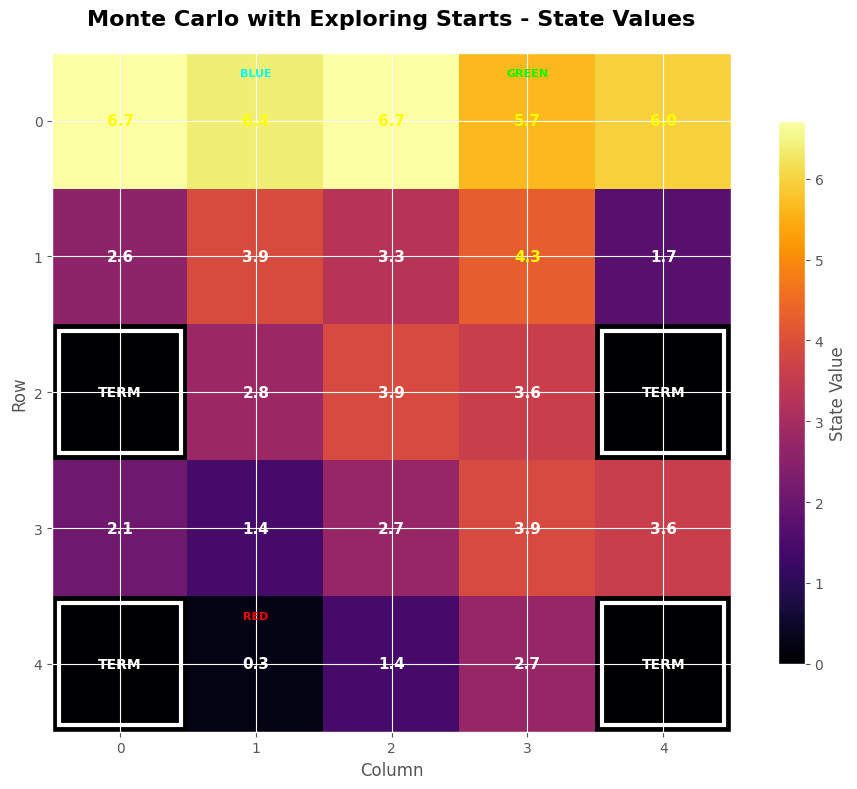


Learned Policy:
-------------------------
| ↑ | ↑ | ↑ | ↑ | ↑ |
| ↑ | ↑ | ↑ | ↑ | ↑ |
|TERM| ↑ | → | ↑ |TERM|
| ← | ↑ | ↑ | ↑ | ← |
|TERM| → | → | ↑ |TERM|
-------------------------

Policy Performance Analysis (1000 test episodes):
Average episode length: 1000.00 ± 0.00
Average episode return: 1.53 ± 8.07
Success rate (episodes < 50 steps): 0.0%


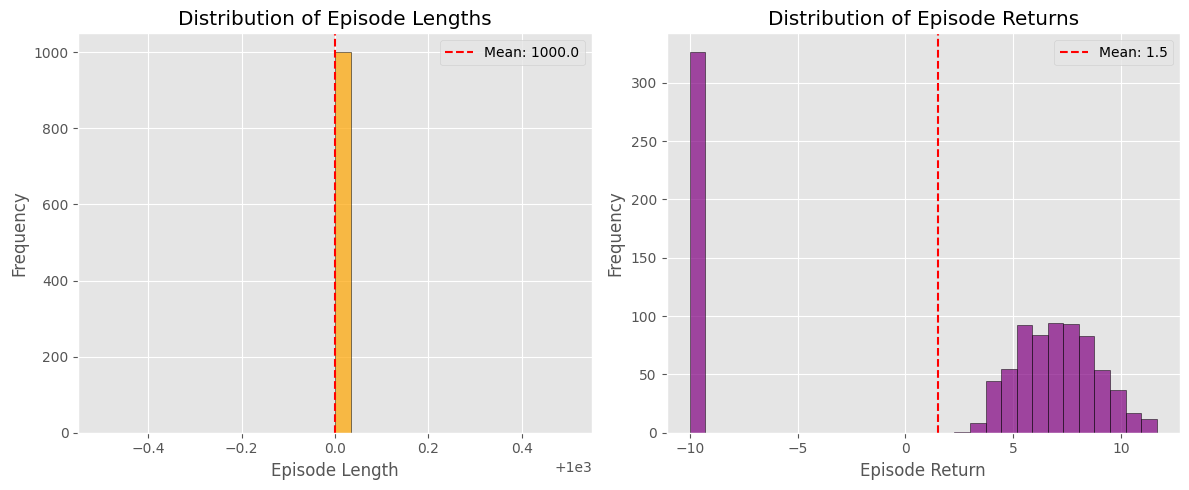


PROBLEM 2: MONTE CARLO WITH EPSILON-SOFT POLICY
Training agent using Monte Carlo with Epsilon-Soft Policy...
Running Monte Carlo with Epsilon-Soft Policy for 10000 episodes...
Episode 2000: Average episode length = 54.0
Episode 4000: Average episode length = 7.8
Episode 6000: Average episode length = 105.0
Episode 8000: Average episode length = 5.7
Episode 10000: Average episode length = 6.9

State values learned with Epsilon-Soft Policy:


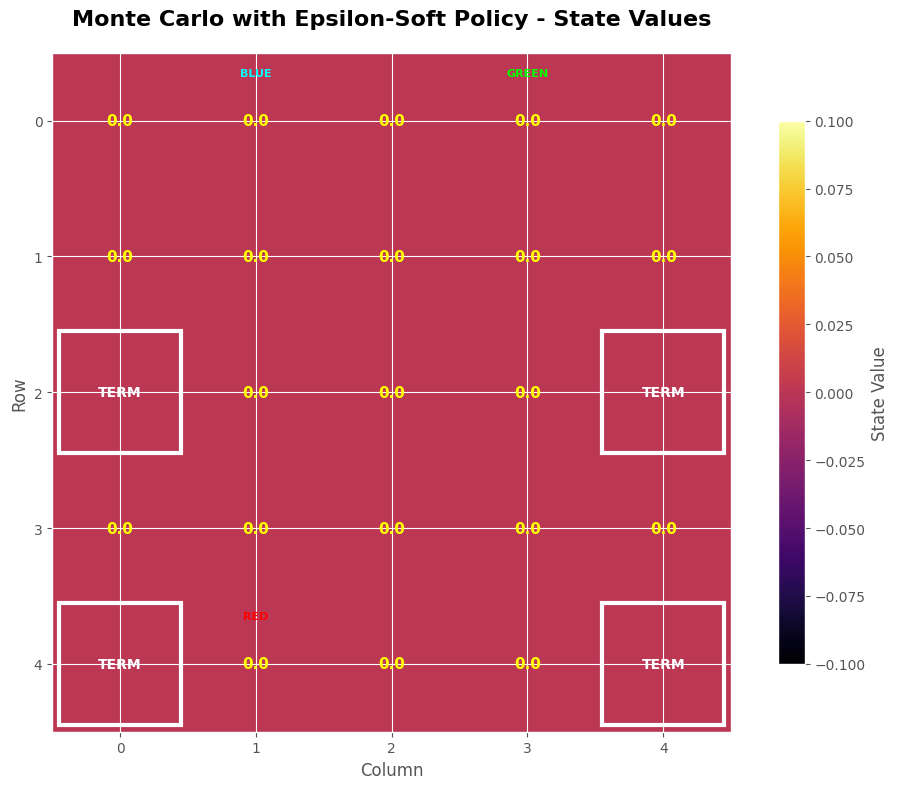


Learned Policy:
-------------------------
| → | ← | ← | ↓ | ← |
| ↑ | ↑ | ← | ↑ | ← |
|TERM| ↑ | ← | ← |TERM|
| → | ← | ↑ | ↑ | ← |
|TERM| ← | ↓ | ↑ |TERM|
-------------------------

Policy Performance Analysis (1000 test episodes):
Average episode length: 150.99 ± 352.45
Average episode return: 1.96 ± 3.74
Success rate (episodes < 50 steps): 85.3%


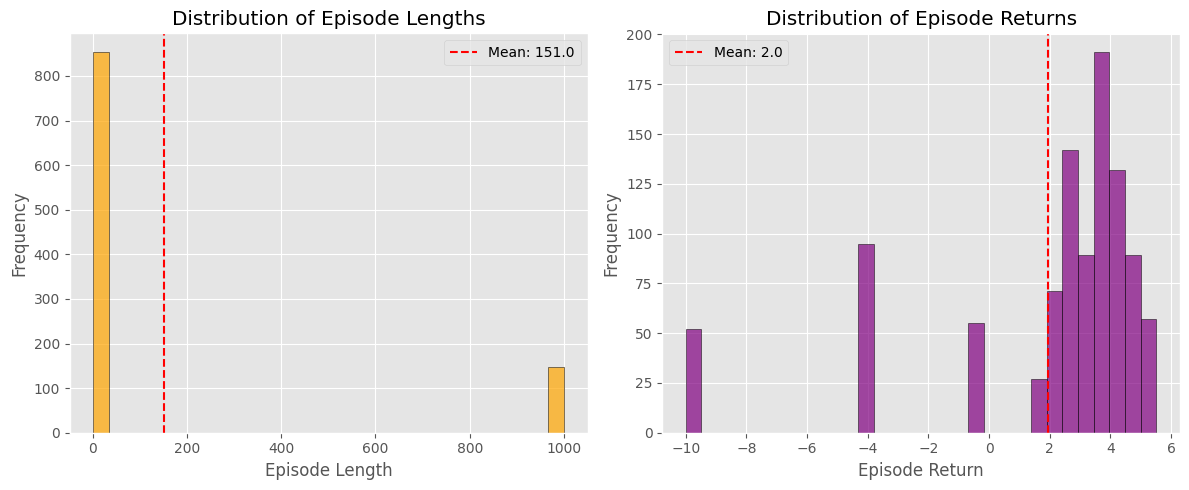

In [8]:
# Creating agent and training with exploring starts
McAgentExploringStarts = MonteCarloAgent(Env, Epsilon=0.1)

# Training the agent
StateValuesExpStarts, PolicyExpStarts = McAgentExploringStarts.MonteCarloExploringStarts(NumEpisodes=10000)

#  results
print("\nState values learned with Exploring Starts:")
PlotGridWorldWithTerminals(StateValuesExpStarts,
                          "Monte Carlo with Exploring Starts - State Values", Env)

# learned policy
PrintPolicyWithTerminals(PolicyExpStarts, Env)

# Analysing the policy performance
AnalyzePolicyPerformance(McAgentExploringStarts, NumTestEpisodes=1000)


print("\n" + "="*60)
print("PROBLEM 2: MONTE CARLO WITH EPSILON-SOFT POLICY")
print("="*60)

# new agent for epsilon-soft learning
McAgentEpsilonSoft = MonteCarloAgent(Env, Epsilon=0.1)

# Training the agent
StateValuesEpsSoft, PolicyEpsSoft = McAgentEpsilonSoft.MonteCarloEpsilonSoft(NumEpisodes=10000)

# results
print("\nState values learned with Epsilon-Soft Policy:")
PlotGridWorldWithTerminals(StateValuesEpsSoft,
                          "Monte Carlo with Epsilon-Soft Policy - State Values", Env)

# Showing the the learned policy
PrintPolicyWithTerminals(PolicyEpsSoft, Env)

# Analysing the policy performance
AnalyzePolicyPerformance(McAgentEpsilonSoft, NumTestEpisodes=1000)



COMPARISON OF MONTE CARLO METHODS
State Value Comparison:
State      Exp. Starts  Eps. Soft    Difference  
--------------------------------------------------
(0, 0)     6.716        0.000        6.716       
(0, 1)     6.397        0.000        6.397       
(0, 3)     5.651        0.000        5.651       
(1, 1)     3.912        0.000        3.912       
(2, 2)     3.907        0.000        3.907       
(3, 3)     3.903        0.000        3.903       
(4, 1)     0.251        0.000        0.251       

Policy Comparison (showing differences):
State (0, 0): Exploring Starts = Up, Epsilon-Soft = Right
State (0, 1): Exploring Starts = Up, Epsilon-Soft = Left
State (0, 2): Exploring Starts = Up, Epsilon-Soft = Left
State (0, 3): Exploring Starts = Up, Epsilon-Soft = Down
State (0, 4): Exploring Starts = Up, Epsilon-Soft = Left
State (1, 2): Exploring Starts = Up, Epsilon-Soft = Left
State (1, 4): Exploring Starts = Up, Epsilon-Soft = Left
State (2, 2): Exploring Starts = Right, Epsilon-

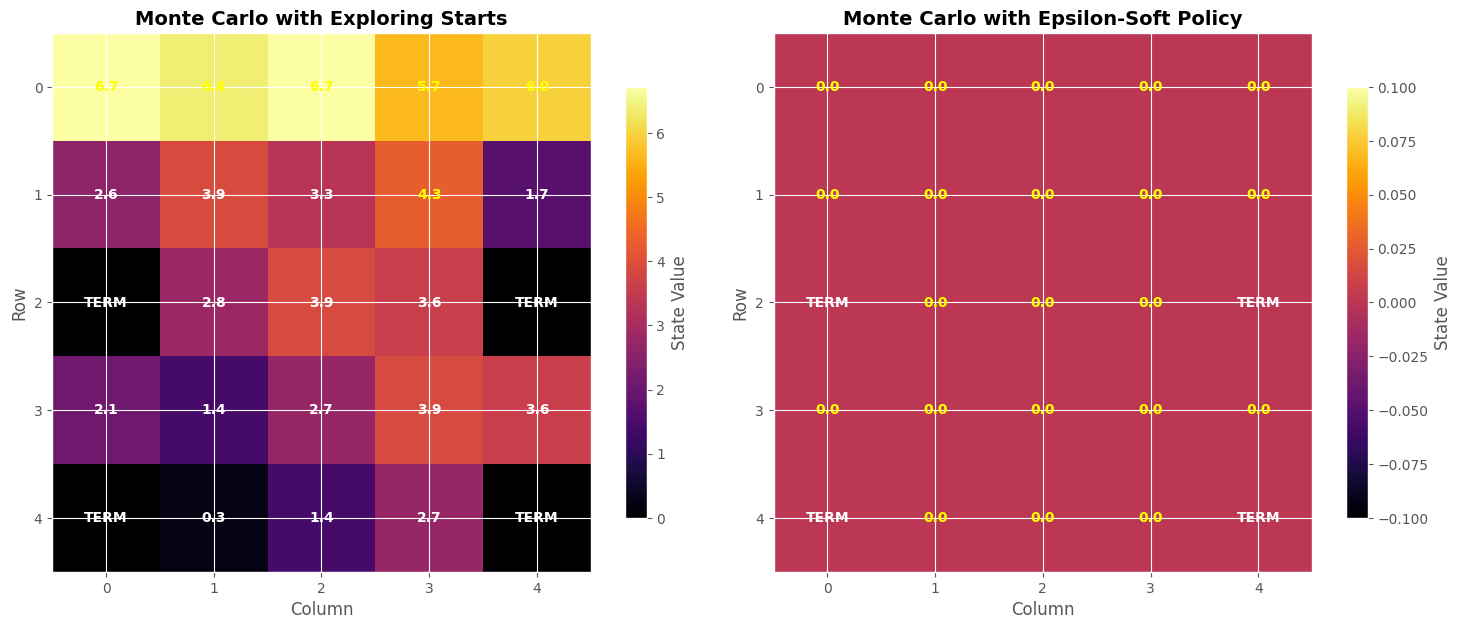


Key Insights:
1. Both methods successfully learn to navigate toward high-reward states
2. Exploring starts may provide more thorough exploration of state-action pairs
3. Epsilon-soft policy maintains some exploration throughout learning
4. Terminal states create natural episode boundaries for learning
5. The -0.2 movement penalty encourages efficient paths to rewarding states


In [9]:

# Comparing the  state values between methods
print("Comparison of the state values:")
print(f"{'State':<10} {'Exp. Starts':<12} {'Eps. Soft':<12} {'Difference':<12}")
print("-" * 50)

ImportantStates = [(0,0), (0,1), (0,3), (1,1), (2,2), (3,3), (4,1)]
for State in ImportantStates:
    if not Env.IsTerminal(State):
        ExpStartsVal = StateValuesExpStarts[State]
        EpsSoftVal = StateValuesEpsSoft[State]
        Difference = ExpStartsVal - EpsSoftVal
        print(f"{str(State):<10} {ExpStartsVal:<12.3f} {EpsSoftVal:<12.3f} {Difference:<12.3f}")

# Comparing the  policies
print("\nPolicy Comparison (showing differences):")
PolicyDifferences = 0
for State in Env.NonTerminalStates:
    if PolicyExpStarts[State] != PolicyEpsSoft[State]:
        PolicyDifferences += 1
        print(f"State {State}: Exploring Starts = {PolicyExpStarts[State]}, "
              f"Epsilon-Soft = {PolicyEpsSoft[State]}")

print(f"\nTotal policy differences: {PolicyDifferences} out of {len(Env.NonTerminalStates)} states")

# side-by-side comparison plot
plt.figure(figsize=(15, 6))

# Plot to look at the starts results
plt.subplot(1, 2, 1)
Grid1 = np.zeros((5, 5))
for (i, j), v in StateValuesExpStarts.items():
    Grid1[i, j] = v

Im1 = plt.imshow(Grid1, cmap='inferno', aspect='equal')
plt.colorbar(Im1, label='State Value', shrink=0.8)
plt.title('Monte Carlo with Exploring Starts', fontsize=14, fontweight='bold')

for i in range(5):
    for j in range(5):
        if not Env.IsTerminal((i, j)):
            Color = 'white' if Grid1[i, j] < np.max(Grid1) * 0.6 else 'yellow'
            plt.text(j, i, f"{Grid1[i, j]:.1f}", ha='center', va='center',
                    color=Color, fontweight='bold')
        else:
            plt.text(j, i, "TERM", ha='center', va='center',
                    color='white', fontweight='bold')

plt.xlabel('Column')
plt.ylabel('Row')
plt.xticks(range(5))
plt.yticks(range(5))

# epsilon-soft results
plt.subplot(1, 2, 2)
Grid2 = np.zeros((5, 5))
for (i, j), v in StateValuesEpsSoft.items():
    Grid2[i, j] = v

Im2 = plt.imshow(Grid2, cmap='inferno', aspect='equal')
plt.colorbar(Im2, label='State Value', shrink=0.8)
plt.title('Monte Carlo with Epsilon-Soft Policy', fontsize=14, fontweight='bold')

for i in range(5):
    for j in range(5):
        if not Env.IsTerminal((i, j)):
            Color = 'white' if Grid2[i, j] < np.max(Grid2) * 0.6 else 'yellow'
            plt.text(j, i, f"{Grid2[i, j]:.1f}", ha='center', va='center',
                    color=Color, fontweight='bold')
        else:
            plt.text(j, i, "TERM", ha='center', va='center',
                    color='white', fontweight='bold')

plt.xlabel('Column')
plt.ylabel('Row')
plt.xticks(range(5))
plt.yticks(range(5))

plt.tight_layout()
plt.show()



both learning methods effectively guide agents toward high-reward states, demonstrating the success of their navigation strategies. Exploring starts enhance the breadth of exploration by exposing a wider range of state-action pairs, contributing to deeper learning. Meanwhile, the epsilon-soft policy preserves a degree of randomness, ensuring continued exploration even as learning progresses. The presence of terminal states introduces natural episode boundaries, streamlining the learning process. Additionally, the imposed movement penalty of -0.2 incentivizes efficient trajectories by subtly discouraging aimless movement and promoting strategic planning.